In [1]:
import numpy as np
import math
from GRAPE import *
import matplotlib.pyplot as plt
from qiskit import Aer, execute

In [2]:
J = np.zeros((3, 3))  # HCN
J[0][1] = 0.1385  # HC
J[1][2] = 0.01304  # CN
J[0][2] = 0.00148  # HN

CX = np.eye(4)
CX[2][2] = 0
CX[3][3] = 0
CX[2][3] = 1
CX[3][2] = 1

SWAP = np.eye(4)
SWAP[1][1] = 0
SWAP[2][2] = 0
SWAP[1][2] = 1
SWAP[2][1] = 1

TOFFOLI = np.eye(8)
TOFFOLI[6][6] = 0
TOFFOLI[7][7] = 0
TOFFOLI[6][7] = 1
TOFFOLI[7][6] = 1

ket_00 = np.array([1,0,0,0]).reshape((4,1))
ket_01 = np.array([0,1,0,0]).reshape((4,1))
ket_10 = np.array([0,0,1,0]).reshape((4,1))
ket_11 = np.array([0,0,0,1]).reshape((4,1))
H = math.sqrt(0.5)*np.array([1,1,1,-1]).reshape(2,2)

U = np.kron(np.array([1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1]).reshape(4,4),np.eye(2))

def F(f):
  A = f(0)*ket_00 @ ket_00.T + f(1)*ket_01 @ ket_01.T + f(2)*ket_10 @ ket_10.T + f(3)*ket_11 @ ket_11.T
  return np.eye(8) + U @ np.kron((H - np.eye(2)), A) @ U

def f1(x): # корни 01
  if x == 1:
    return 1
  return 0

def f2(x): # корни 00 01
  if x == 1:
    return 1
  if x == 0:
    return 1
  return 0

def f3(x): # корни 01 11
  if x == 1:
    return 1
  if x == 3:
    return 1
  return 0

def f4(x): # корни 01 10
  if x == 1:
    return 1
  if x == 2:
    return 1
  return 0

def f5(x): # корни 01 10 11
  if x == 1:
    return 1
  if x == 2:
    return 1
  if x == 3:
    return 1
  return 0

# нужно построить последовательность для этих матриц. J_12 = J_HC  J_13 = J_CN  J_23 = J_HN - первый спин это углерод, его спектр мне и нужен
F1 = F(f1)
F2 = F(f2)
F3 = F(f3)
F4 = F(f4)
F5 = F(f5)

[[0.     +0.j 0.1385 +0.j 0.00148+0.j]
 [0.     +0.j 0.     +0.j 0.01304+0.j]
 [0.     +0.j 0.     +0.j 0.     +0.j]]


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.j[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)


distance: 4.235549 ; time: 2.01


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.j[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(


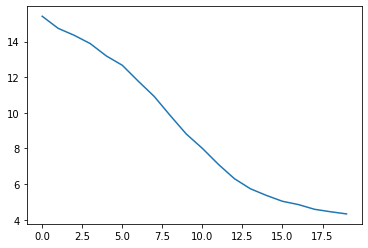

In [3]:
n = 1
m = 20
k = 8

descents = [ThreeQubitGradient(F1, k) for _ in range(n)]

for descent in descents:
    descent.noise = 1
    descent.randomize_params()
    descent.set_j(J)

print(descents[0].gates[1].j)

losses = [descent.descend(steps=m, track_distance=True) for descent in descents]

for loss in losses:
    plt.plot(np.real(loss))
for descent in descents:
    descent.make_times_positive()
    print("distance:", descent.distance.round(6).real, "; time:", descent.time.round(2))



C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:464: ComplexWarning: Casting complex values to real discards the imaginary part
  if np.random.binomial(1, p_up):
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:470: ComplexWarning: Casting complex values to real discards the imaginary part
  if np.random.binomial(1, p_down):
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)


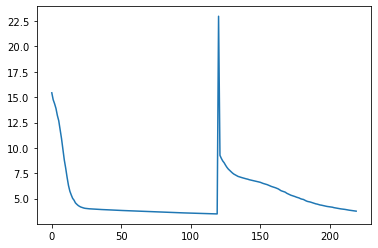

In [4]:
for n in range(10):
  for i in range(len(descents)):
    descents[i].hyper_step()
    losses[i] += descents[i].descend(steps=m, track_distance=True)
    descents[i].make_times_positive()

for loss in losses:
    plt.plot(np.real(loss))